Let's have a look at how to implement KNN and K-means in Python. Again, we need to first import the required packages and load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score, roc_curve
pd.set_option('display.max_columns', 50) # Display up to 50 columns
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os.path

# Check if the file exists
if not os.path.isfile('data/card_transdata.csv'):

    print('Downloading dataset...')

    # Define the dataset to be downloaded
    zipurl = 'https://www.kaggle.com/api/v1/datasets/download/dhanushnarayananr/credit-card-fraud'

    # Download and unzip the dataset in the data folder
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('data')

    print('DONE!')

else:

    print('Dataset already downloaded!')

# Load the data
df = pd.read_csv('data/card_transdata.csv')

Dataset already downloaded!


This is the **dataset of credit card transactions** from [Kaggle.com](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data) which we have used before. Recall that the target variable $y$ is `fraud`, which indicates whether the transaction is fraudulent or not. The other variables are the features $x$ of the transactions.

In [2]:
df.head(20)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


In [3]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


### Data Preprocessing

Since we have already explored the dataset in the previous notebook, we can skip that part and move directly to the data preprocessing. 

We will again split the data into training and test sets using the `train_test_split` function

In [5]:
X = df.drop('fraud', axis=1) # All variables except `fraud`
y = df['fraud'] # Only our fraud variables
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

Then we can do the feature scaling to ensure our non-binary variables have mean zero and variance 1

In [6]:
def scale_features(scaler, df, col_names, only_transform=False):

    # Extract the features we want to scale
    features = df[col_names] 

    # Fit the scaler to the features and transform them
    if only_transform:
        features = scaler.transform(features.values)
    else:
        features = scaler.fit_transform(features.values)

    # Replace the original features with the scaled features
    df[col_names] = features


# Define which features to scale with the StandardScaler and MinMaxScaler
for_standard_scaler = [
    'distance_from_home', 
    'distance_from_last_transaction', 
    'ratio_to_median_purchase_price',
]

# Apply the standard scaler (Note: we use the same mean and std for scaling the test set)
standard_scaler = StandardScaler() 
scale_features(standard_scaler, X_train, for_standard_scaler)
scale_features(standard_scaler, X_test, for_standard_scaler, only_transform=True)

### K-Nearest Neighbors (KNN)

We can now implement the KNN algorithm using the `KNeighborsClassifier` class from the `sklearn.neighbors` module. We will use the default value of $k=5$ for the number of neighbors.

In [7]:
clf_knn = KNeighborsClassifier().fit(X_train, y_train)

We can now use the trained model to make predictions on the test set and evaluate the model performance using the confusion matrix and accuracy score.

In [8]:
y_pred_knn = clf_knn.predict(X_test)
y_proba_knn = clf_knn.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(f"Precision: {precision_score(y_test, y_pred_knn)}")
print(f"Recall: {recall_score(y_test, y_pred_knn)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_knn[:, 1])}")

Accuracy: 0.9987
Precision: 0.9935419771485345
Recall: 0.991571641051066
ROC AUC: 0.9997341251520317


This seems to work quite well with a ROC AUC of 0.9997. We seem to have an almost perfect classifier. We can also plot the ROC curve to visualize the performance of the classifier

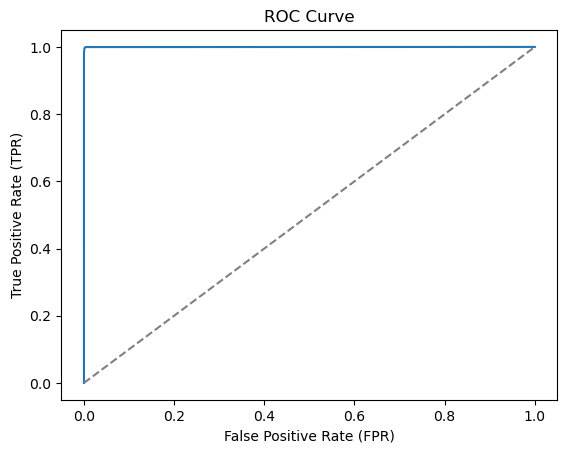

In [9]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_knn[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.show()

Let's also check the confusion matrix to see where we still make mistakes

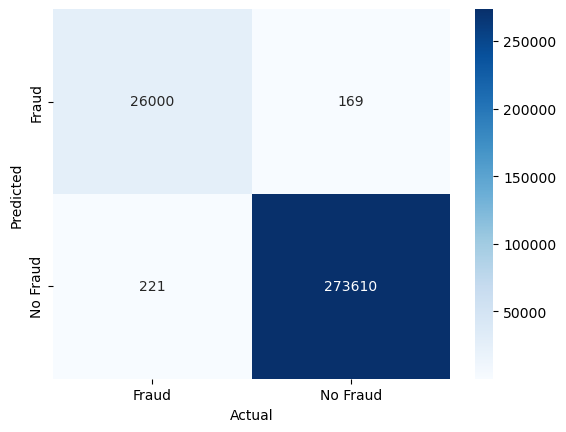

In [10]:
conf_mat = confusion_matrix(y_test, y_pred_knn, labels=[1, 0]).transpose() # Transpose the sklearn confusion matrix to match the convention in the lecture
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Fraud', 'No Fraud'], yticklabels=['Fraud', 'No Fraud'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### K-Means

This is the first example of an unsupervised learning algorithm meaning that we will ignore the labels in the training set. We will use the `KMeans` class from the `sklearn.cluster` module to implement the K-means algorithm. Note that we can not use categorical variables in the K-means algorithm, so we will only use the continuous variables in this example. Furthermore, to simplify interpretability we will only use two variables

In [11]:
continuous_variables = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
n_clusters=2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(X_train[continuous_variables])

We can check the cluster centers using the `cluster_centers_` attribute of the trained model

In [12]:
kmeans.cluster_centers_

array([[-2.01860525e-05, -1.55050548e-03, -1.68843633e-01],
       [ 3.66287246e-04,  2.81347918e-02,  3.06376244e+00]])

Since we only have two variables we can easily visualize the clusters using a scatter plot. We first need to unscale the data to make the plot more interpretable

In [13]:
# Unscale the data
X_train_unscaled = X_train.copy()
X_train_unscaled[for_standard_scaler] = standard_scaler.inverse_transform(X_train[for_standard_scaler])
X_test_unscaled = X_test.copy()
X_test_unscaled[for_standard_scaler] = standard_scaler.inverse_transform(X_test[for_standard_scaler])
cluster_centers = standard_scaler.inverse_transform(kmeans.cluster_centers_)

Then, we can create the scatter plot to see what the clusters look like

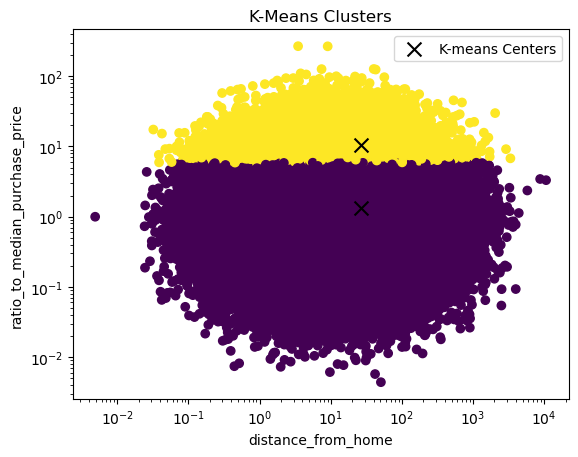

In [14]:
_, ax = plt.subplots()
scatter = ax.scatter(X_train_unscaled[continuous_variables[0]], X_train_unscaled[continuous_variables[2]], c=kmeans.labels_)
scatter = ax.scatter(cluster_centers[:, 0], cluster_centers[:, 2], c='black', marker='x', s=100, label = 'K-means Centers')
ax.set(xlabel=continuous_variables[0], ylabel=continuous_variables[2])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.title('K-Means Clusters')
plt.show()

Note that the centers might look a bit off because we are using log scales on the x and y-axis. In the other dimension, we don't have such a nice separation of the clusters

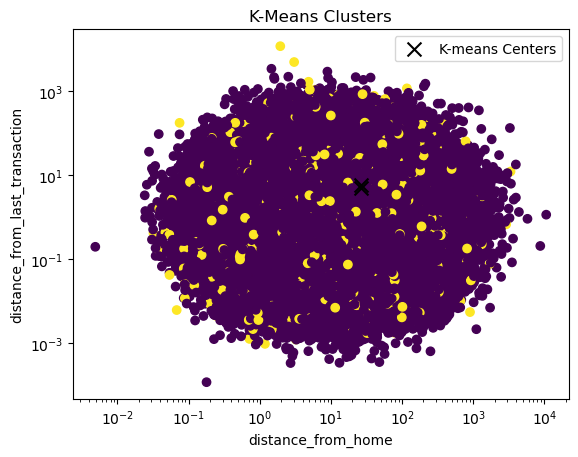

In [15]:
_, ax = plt.subplots()
scatter = ax.scatter(X_train_unscaled[continuous_variables[0]], X_train_unscaled[continuous_variables[1]], c=kmeans.labels_)
scatter = ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', s=100, label = 'K-means Centers')
ax.set(xlabel=continuous_variables[0], ylabel=continuous_variables[1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.title('K-Means Clusters')
plt.show()

But what do these two clusters represent? We can check the mean of the target variable `fraud` for each cluster to get an idea of what the clusters represent

In [16]:
X_train_unscaled['cluster'] = kmeans.labels_
X_train_unscaled.query('cluster == 1').describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,36679.0,26.727628,63.910540,0.032026,3.895800,10.098703,25.760347,3353.002414
distance_from_last_transaction,36679.0,5.780037,71.723799,0.000966,0.296198,1.000376,3.357238,11851.104565
ratio_to_median_purchase_price,36679.0,10.470287,6.811775,2.209891,6.871869,8.384989,11.466176,267.802942
repeat_retailer,36679.0,0.879522,0.325524,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,36679.0,0.351754,0.477524,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,36679.0,0.102756,0.303645,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,36679.0,0.649063,0.477270,0.000000,0.000000,1.000000,1.000000,1.000000
cluster,36679.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
X_train_unscaled.query('cluster == 0').describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,663321.0,26.694233,66.097113,0.004874,3.880252,9.969293,25.807909,10632.723672
distance_from_last_transaction,663321.0,4.988030,22.054240,0.000118,0.296681,0.998050,3.351187,3437.278746
ratio_to_median_purchase_price,663321.0,1.347721,1.226094,0.004399,0.455014,0.929070,1.838841,5.921543
repeat_retailer,663321.0,0.881468,0.323238,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,663321.0,0.350518,0.477133,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,663321.0,0.100512,0.300682,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,663321.0,0.650643,0.476767,0.000000,0.000000,1.000000,1.000000,1.000000
cluster,663321.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
y_train[X_train_unscaled['cluster'] == 0].mean()

0.057474435454327545

In [19]:
y_train[X_train_unscaled['cluster'] == 1].mean()

0.6286430927778838

There does not seem to be a clear difference between the two clusters except for the difference in the mean of the ratio_to_median_purchase_price variable. This is not necessarily very surprising since we only used three variables in the clustering algorithm. However, due to the correlation of `ratio_to_median_purchase_price` we have more fraudulent transactions in one cluster than the other.  To be able to carry out a more meaningful clustering analysis using K-means we would need a different dataset with more quantitative variables. Nevertheless, let's also check the elbow method to how many clusters it would suggest

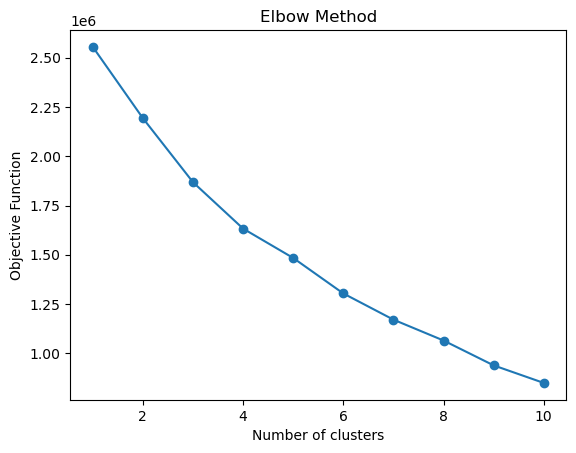

In [20]:
interias = [KMeans(n_clusters=n, n_init=10).fit(X_train).inertia_ for n in range(1, 11)]
_, ax = plt.subplots()
ax.plot(range(1, 11), interias, marker='o')
ax.set(xlabel='Number of clusters', ylabel='Objective Function')
plt.title('Elbow Method')
plt.show()

There does not seem to be a clear elbow in the plot. Finally, we can also make predictions on the test set using the trained K-means model

In [21]:
kmeans.predict(X_test[continuous_variables])

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

This assigns each observation in the test set to one of the two clusters.


### Conclusions

We have seen how to implement a KNN algorithm for classification and a K-means algorithm for clustering in Python using the `sklearn` package. We have also seen how to evaluate the performance of the KNN algorithm using the confusion matrix, accuracy score, precision, recall, and ROC AUC. We have also seen how to visualize the clusters created by the K-means algorithm and tried to apply the ellow method.